## Процесс создания модели

Импортируем необходимые библиотеки. Для работы нам потрбуется, в основном библиотеки pandas и sklearn. Если какая-либо
библиотека отсутствует или не установлена на рабочей машине, её можно установить, набрав команду pip install lib_name в командной строке.

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression as log_reg, LinearRegression as lr_reg
from sklearn.ensemble import RandomForestClassifier as rf, RandomForestRegressor as rf_reg
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import time
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

### Загрузим данные для работы.

Датасет с инфоромацией по различным фруктам и их параметрам.

In [2]:
fruits = pd.read_csv('datasets/fruit_data_with_colors.txt', sep='\t')
fruits.drop('fruit_subtype', axis=1, inplace=True)
fruits.head()

,fruit_label,fruit_name,mass,width,height,color_score
0,1,apple,192,8.4,7.3,0.55
1,1,apple,180,8.0,6.8,0.59
2,1,apple,176,7.4,7.2,0.60
3,2,mandarin,86,6.2,4.7,0.80
4,2,mandarin,84,6.0,4.6,0.79


In [3]:
# Проверяем уникальные значения
fruits.fruit_name.unique()

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

In [4]:
# Получаем размер датасета
fruits.shape

(59, 6)

In [5]:
# Проверяем датасет на наличие пропущенных данных
fruits.isnull().values.any()

False

Посмотрим описательную статистику данных (среднее, стандартное отклонение, мин/макс значений и квартили). Данная операция легко выполняется с испльзованием функции pandas describe(). По значением среднего, мин/макса и отклонения, сразу видно, что переменные имеют раличные шкалы - к примеру шкала переменной mass значительно отличается от шкалы других переменных.
Поэтому в дальнейшем мы должны провести шкалирование данных (стандартизацию) для того, чтобы привести их к единой шкале. Это позволит нашей модели работать более чтоно. Если этого не делать, то переменная с большой шкалой будет иметь больший вес а модели, ухудшая её качество.

In [6]:
fruits.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


Подготовим даггын к разработкн модели классификации - выделим признаковое множество X и целевую переменную y. В данном случае мы будем предсказывать лейбл фруктов.

In [7]:
X = fruits[['mass', 'width', 'height', 'color_score']]
y = fruits['fruit_label']

<IPython.core.display.Javascript object>


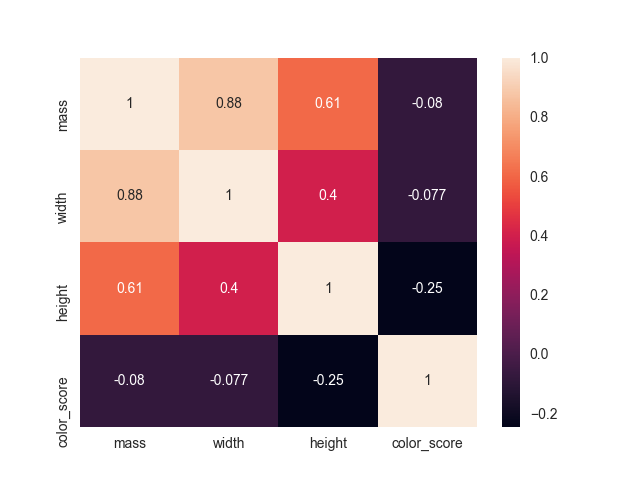

<AxesSubplot:>

In [8]:
corr = X.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Построим scatter plot для дальнейшего анализа даннх. Результаты построения показывают сильную зависимость переменной mass и width, ранее подтвержденную в ходе проведения корреляционного анализа. Так же мы можем заметить, что хоть данные не имеют
нормального распределения, однако распределение достаточно близко к нормальному. Поэтому вам не нужно будет осуществлять по типу log трансформации для привода данных в нормальное распределение для улучшения работы модели и мы можем ограничиться только шкалированием переменых.

<IPython.core.display.Javascript object>


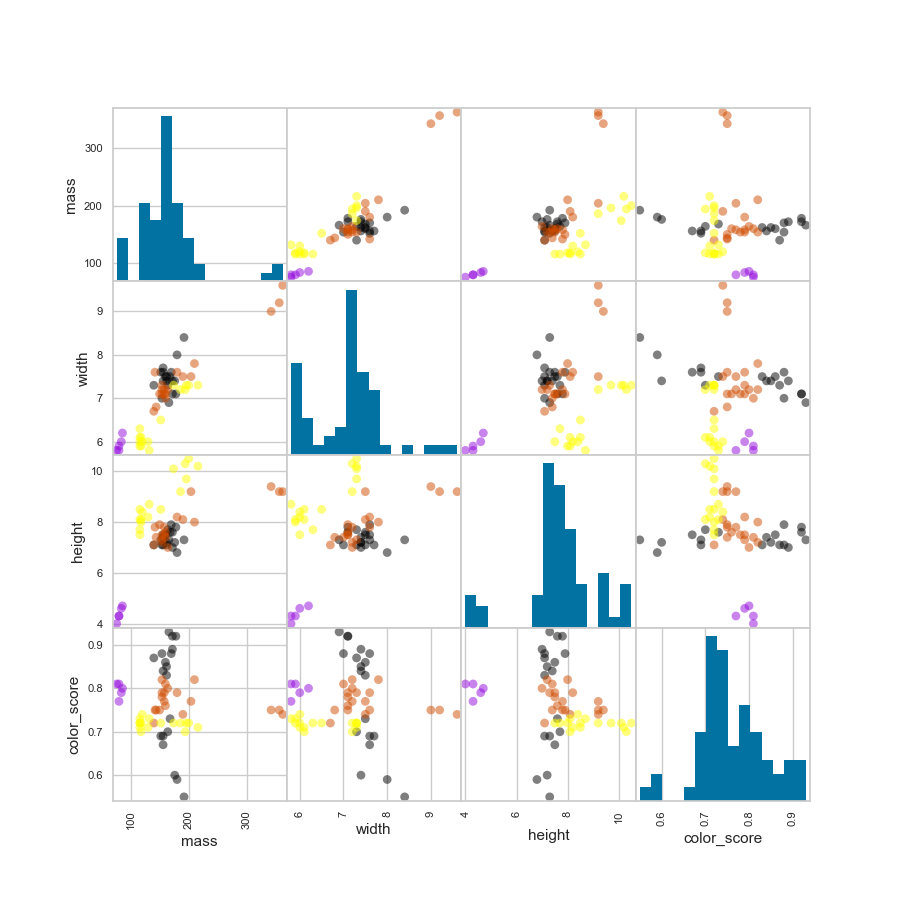

In [9]:
cmap = plt.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s = 40, hist_kwds={'bins':15}, figsize=(9, 9), cmap=cmap)

Проведем кроссвалидацию данных, для того, чтобы изюежать переобучения модели. Используем подход KFold с n_folds=10, который является основным для данной процедуры. Его идея состоит в том, что тренировка модели происходит на k-1 выборках (фолдах), а
валидация на оставщемся фолде. Создадим функцию cv() в которой будет осуществляться процесс кросс-валидации. Данная функция будет принимать на вход признаковое множество X, целевую переменную y и выбранный алгоритм.

In [10]:
def cv(X, y, clf_class):
    kf = KFold(n_splits=10, shuffle=False)
    
    y_pred = y.copy()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class()
        clf.fit(X_train, y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

In [11]:
X = StandardScaler().fit_transform(X)

In [12]:
print(accuracy_score(y, cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.3898305084745763
0.41777557031794327
0.46234340456890194
0.3898305084745763


In [13]:
print(accuracy_score(y, cv(X, y, rf)))
print(f1_score(y, cv(X, y, rf),average='weighted'))
print(precision_score(y, cv(X, y, rf),average='weighted'))
print(recall_score(y, cv(X, y, rf),average='weighted'))

0.7966101694915254
0.7812453942520264
0.8418079096045198
0.8135593220338984


In [14]:
print(accuracy_score(y, cv(X, y, gb)))
print(f1_score(y, cv(X, y, gb),average='weighted'))
print(precision_score(y, cv(X, y, gb),average='weighted'))
print(recall_score(y, cv(X, y, gb),average='weighted'))

0.7796610169491526
0.7724346340822494
0.7826876513317191
0.7796610169491526


In [15]:
def cv(X, y, clf_class):
    kf = KFold(n_splits=10, shuffle=False)
    y_pred = y.copy()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train, y_train)
        
        penalty = ['l1', 'l2']
        C = np.logspace(0, 4, 10)
        hyperparameters = dict(C=C, penalty=penalty)
        
        clf = GridSearchCV(clf, hyperparameters, cv=10, verbose=0)
        best_model = clf.fit(X_train, y_train)
        
        y_pred[test_index] = best_model.predict(X_test)
    
    return y_pred

In [16]:
print(accuracy_score(y, cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.5932203389830508
0.5959096223001595
0.6013323665367535
0.5932203389830508


Так же данные для модели можно готовить не применяя валидационный сет, а просто деля выборку случайным образом на
тренировочный и тестовый сеты (к примеру, с помощью метода train_test_split()). Однако, данный подход вреват тем, что
модельможет переобучиться и показать неопределенно завышенные результаты, которые являются следствием непрравильной 
тренировки модели. Это отчетливо можно увидеть при построении learning_curve и оценке графика. Желательно во всех случаях
стараться использовать кросс-валидацию, к примеру KFold.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=0)

In [18]:
logistic_regression = log_reg()

In [19]:
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [20]:
y_pred = logistic_regression.predict(X_test)

In [21]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.6
0.5422969187675071
0.8166666666666668
0.6


In [22]:
random_forest = rf()

In [23]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
y_pred = random_forest.predict(X_test)

In [25]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.95
0.9522556390977442
0.9625
0.95


In [26]:
grad_boost = gb()

In [27]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier()

In [28]:
y_pred = grad_boost.predict(X_test)

In [29]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.85
0.8617647058823529
0.925
0.85


In [31]:
X = fruits[['fruit_label', 'width', 'height', 'color_score']]
y = fruits['mass']

In [32]:
X = StandardScaler().fit_transform(X)